In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd='ian1991'
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
print(tf.__version__)

2.6.0


# 取 X值 (20183-20211)

In [7]:
company_factor = get_data("""SELECT 
                            operating_gross_rate,
                            net_profit_rate,
                            revenue_growth_rate,
                            current_rate, 
                            quick_rate,  
                            debt_rate,  
                            receivables_turnover_rate, 
                            debt_growth_rate,
                            cash_reinvest_rate,
                            avg_director_rate, 
                            avg_director_pledge_rate, 
                            foreign_rate_bys, 
                            over1000_rate_bys, 
                            under400_rate_bys, 
                            avg_board_bys
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

#稅後淨利率 #營業毛利率 #流動比率 #速動比率 #負債比率 #應收帳款週轉率  #現金再投資比率 #董監事持股比利 
#董監事質押比利 #外資持股比例 # >1000張大股東持股比率 # <400張股東持股比率
#平均持股張數

company_factor

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,debt_growth_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys
0,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.22,1.74,26.60,0.00,4.40,62.23,33.99,8.73
1,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,-5.28,1.34,26.60,0.00,4.40,62.35,34.08,8.86
2,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,-14.95,1.51,26.60,0.00,4.37,62.53,33.68,8.90
3,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,-17.02,2.17,26.60,0.00,4.30,62.34,33.51,9.01
4,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,-4.23,4.32,26.60,0.00,4.30,62.33,33.44,9.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-10.18,-0.03,17.70,12.77,56.57,45.83,38.01,10.07
1635,24.76,10.91,10.95,299.48,181.73,27.74,4.28,-10.08,6.49,17.70,12.73,51.13,41.64,44.76,7.51
1636,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,6.96,5.25,18.23,17.90,45.53,37.24,51.68,6.58
1637,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,6.71,11.28,18.40,17.80,47.07,36.67,51.03,6.80


# 取 Y值 (20184-20212)

In [8]:
Roe_rul = get_data("""SELECT roe_rate
                      FROM tfb103d_project.datamining_alldata_afetl
                      WHERE stock_report_date > '20183';""",'tfb103d_project')
Roe_rul

,roe_rate
0,0.42
1,-0.20
2,0.85
3,0.17
4,-0.80
...,...
1634,4.01
1635,6.07
1636,11.76
1637,4.71


<h1>資料前處理

In [9]:
#缺值檢視
company_factor.isnull().sum()

operating_gross_rate         0
net_profit_rate              0
revenue_growth_rate          0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
debt_growth_rate             0
cash_reinvest_rate           0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
dtype: int64

In [10]:
Roe_rul.isnull().sum()

roe_rate    0
dtype: int64

In [11]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0

In [12]:
#定義股東權益報酬率 >平均者為表現良好
m2 = Roe_rul['roe_rate'].mean()
Roe_rul['roe_rate1'] = Roe_rul.apply(lambda r : encoding(r['roe_rate'],m2), axis = 1)

<h3>將挑選出來的特徵與應變數(y)比較

<AxesSubplot:>

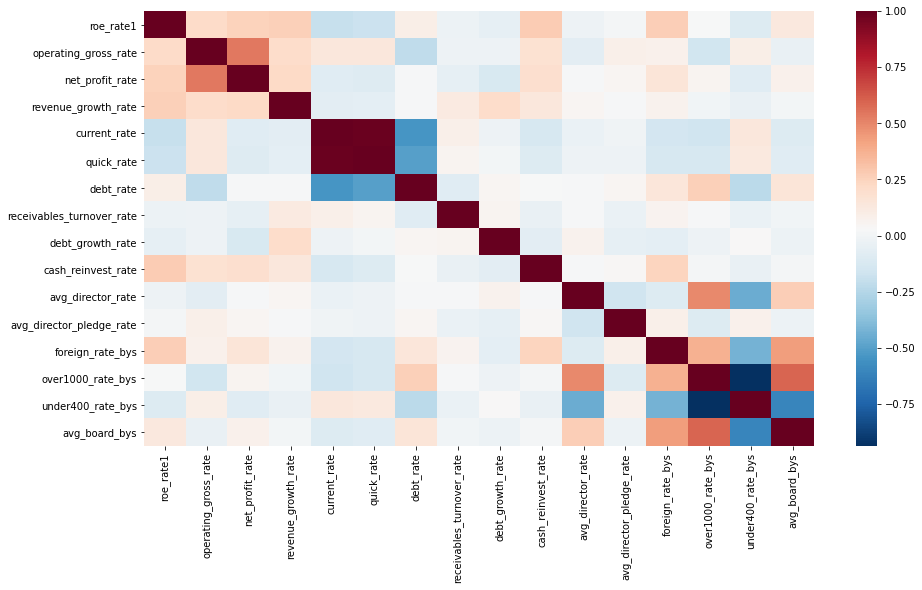

In [13]:
df = pd.merge(Roe_rul['roe_rate1'], company_factor,left_index=True, right_index=True)
plt.figure(figsize = (15,8))
corr = df.corr()
sns.heatmap(corr, cmap="RdBu_r")

<h3>與 y 的相關係數

In [14]:
df.corr()['roe_rate1']

roe_rate1                    1.000000
operating_gross_rate         0.220831
net_profit_rate              0.252212
revenue_growth_rate          0.262203
current_rate                -0.190676
quick_rate                  -0.176265
debt_rate                    0.099070
receivables_turnover_rate   -0.021771
debt_growth_rate            -0.052062
cash_reinvest_rate           0.277222
avg_director_rate           -0.020064
avg_director_pledge_rate     0.010512
foreign_rate_bys             0.268198
over1000_rate_bys            0.030884
under400_rate_bys           -0.103462
avg_board_bys                0.134695
Name: roe_rate1, dtype: float64

<h3>篩選高相關性特徵

In [15]:
df.corr()['roe_rate1'].abs()> 0.15

roe_rate1                     True
operating_gross_rate          True
net_profit_rate               True
revenue_growth_rate           True
current_rate                  True
quick_rate                    True
debt_rate                    False
receivables_turnover_rate    False
debt_growth_rate             False
cash_reinvest_rate            True
avg_director_rate            False
avg_director_pledge_rate     False
foreign_rate_bys              True
over1000_rate_bys            False
under400_rate_bys            False
avg_board_bys                False
Name: roe_rate1, dtype: bool

In [16]:
high_corr = df.columns[df.corr()['roe_rate1'].abs()> 0.1]
high_corr = high_corr.drop('roe_rate1')
high_corr

Index(['operating_gross_rate', 'net_profit_rate', 'revenue_growth_rate',
       'current_rate', 'quick_rate', 'cash_reinvest_rate', 'foreign_rate_bys',
       'under400_rate_bys', 'avg_board_bys'],
      dtype='object')

<h3> 將高相關性特徵列為 X

In [17]:
X = company_factor[high_corr]

y = Roe_rul['roe_rate1']

print("x.shape: " ,X.shape)
print("y.shape: " ,y.shape)
print('y:',y.value_counts(normalize = True))

x.shape:  (1639, 9)
y.shape:  (1639,)
y: 1    0.539353
0    0.460647
Name: roe_rate1, dtype: float64


<h3> ROE:  755 筆標記為 0 ； 884 筆為 1
<h3> 基準準確度(空準確度) 為 53.93%

In [18]:
# 輸入數據調成標準值以免各特徵影響不同
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=1)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 9


# 1. 以財務數據預測 ROE

In [20]:
# 建立TF模型 for 淨利
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 訓練模型
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/100
41/41 [==============================] - 1s 4ms/step - loss: 0.6685 - accuracy: 0.5850 - val_loss: 0.6402 - val_accuracy: 0.7104
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6153 - accuracy: 0.6979 - val_loss: 0.5922 - val_accuracy: 0.7226
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5843 - accuracy: 0.7254 - val_loss: 0.5571 - val_accuracy: 0.7317
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5608 - accuracy: 0.7307 - val_loss: 0.5357 - val_accuracy: 0.7439
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5451 - accuracy: 0.7529 - val_loss: 0.5206 - val_accuracy: 0.7530
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7536 - val_loss: 0.5119 - val_accuracy: 0.7591
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5218 - accuracy: 0.7727 - val_loss: 0.5061 - val_accuracy: 0.7652
Epoch 8/100
4

Epoch 59/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4484 - accuracy: 0.8009 - val_loss: 0.4660 - val_accuracy: 0.7805
Epoch 60/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4593 - accuracy: 0.7879 - val_loss: 0.4678 - val_accuracy: 0.7835
Epoch 61/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4493 - accuracy: 0.7956 - val_loss: 0.4667 - val_accuracy: 0.7896
Epoch 62/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4492 - accuracy: 0.7925 - val_loss: 0.4655 - val_accuracy: 0.7896
Epoch 63/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.7910 - val_loss: 0.4643 - val_accuracy: 0.7896
Epoch 64/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4461 - accuracy: 0.7948 - val_loss: 0.4645 - val_accuracy: 0.7896
Epoch 65/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4434 - accuracy: 0.7994 - val_loss: 0.4646 - val_accuracy: 0.7927
Epoch 

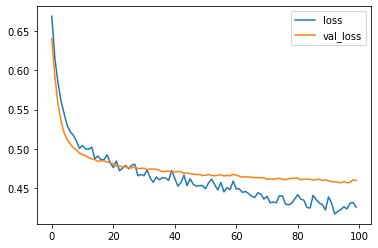

In [23]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

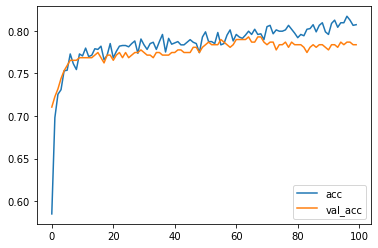

In [24]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [25]:
pred_test = model.predict(X_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[109,  39],
       [ 32, 148]], dtype=int64)

In [152]:
#model3.save('./ROE_model.h5')

# 2.加入進口環境因素預測 ROE

<h2>資料前處理

In [195]:
#取得需要的特徵
addenv_factor = get_data("""SELECT 
                            operating_gross_rate,
                            net_profit_rate,
                            revenue_growth_rate,
                            current_rate, 
                            quick_rate,  
                            debt_rate,  
                            receivables_turnover_rate, 
                            debt_growth_rate,
                            cash_reinvest_rate,
                            avg_director_rate, 
                            avg_director_pledge_rate, 
                            foreign_rate_bys, 
                            over1000_rate_bys, 
                            under400_rate_bys, 
                            avg_board_bys
                            import_kgm_weight_2801, 
                            import_kgm_weight_2804, 
                            import_kgm_weight_37071000,
                            import_kgm_weight_37079090,
                            import_kgm_weight_37050000306,
                            import_kgm_weight_848620,
                            import_kgm_weight_848610,
                            import_kgm_weight_381800,
                            import_usd_value_2801,
                            import_usd_value_2804,
                            import_usd_value_37071000,
                            import_usd_value_37079090,
                            import_usd_value_37050000306,
                            import_usd_value_848620,
                            import_usd_value_848610,
                            import_usd_value_381800,
                            avg_import_rate
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')
addenv_factor

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,debt_growth_rate,cash_reinvest_rate,avg_director_rate,...,import_kgm_weight_381800,import_usd_value_2801,import_usd_value_2804,import_usd_value_37071000,import_usd_value_37079090,import_usd_value_37050000306,import_usd_value_848620,import_usd_value_848610,import_usd_value_381800,avg_import_rate
0,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.22,1.74,26.60,...,1409793,862,46597,2987,54333,27410,675685,44346,242172,30.719
1,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,-5.28,1.34,26.60,...,1053753,834,48412,498,59877,20281,519909,30940,228487,30.901
2,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,-14.95,1.51,26.60,...,1034009,732,39213,288,54298,20181,908995,51369,215901,30.880
3,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,-17.02,2.17,26.60,...,898797,739,38985,934,58250,21878,744366,34141,218212,31.187
4,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,-4.23,4.32,26.60,...,856956,680,30999,546,64807,25203,991427,24335,206041,31.248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-10.18,-0.03,17.70,...,851896,920,44500,419,69400,19159,877494,49017,219185,30.163
1635,24.76,10.91,10.95,299.48,181.73,27.74,4.28,-10.08,6.49,17.70,...,673790,777,34092,613,74795,21977,640466,26651,223348,29.941
1636,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,6.96,5.25,18.23,...,693142,795,35919,201,73581,22766,854227,36716,213329,29.499
1637,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,6.71,11.28,18.40,...,686162,847,41139,308,76867,23473,1333417,29918,226517,28.783


In [196]:
addenv_factor.isnull().sum()

operating_gross_rate             0
net_profit_rate                  0
revenue_growth_rate              0
current_rate                     0
quick_rate                       0
debt_rate                        0
receivables_turnover_rate        0
debt_growth_rate                 0
cash_reinvest_rate               0
avg_director_rate                0
avg_director_pledge_rate         0
foreign_rate_bys                 0
over1000_rate_bys                0
under400_rate_bys                0
import_kgm_weight_2801           0
import_kgm_weight_2804           0
import_kgm_weight_37071000       0
import_kgm_weight_37079090       0
import_kgm_weight_37050000306    0
import_kgm_weight_848620         0
import_kgm_weight_848610         0
import_kgm_weight_381800         0
import_usd_value_2801            0
import_usd_value_2804            0
import_usd_value_37071000        0
import_usd_value_37079090        0
import_usd_value_37050000306     0
import_usd_value_848620          0
import_usd_value_848

<AxesSubplot:>

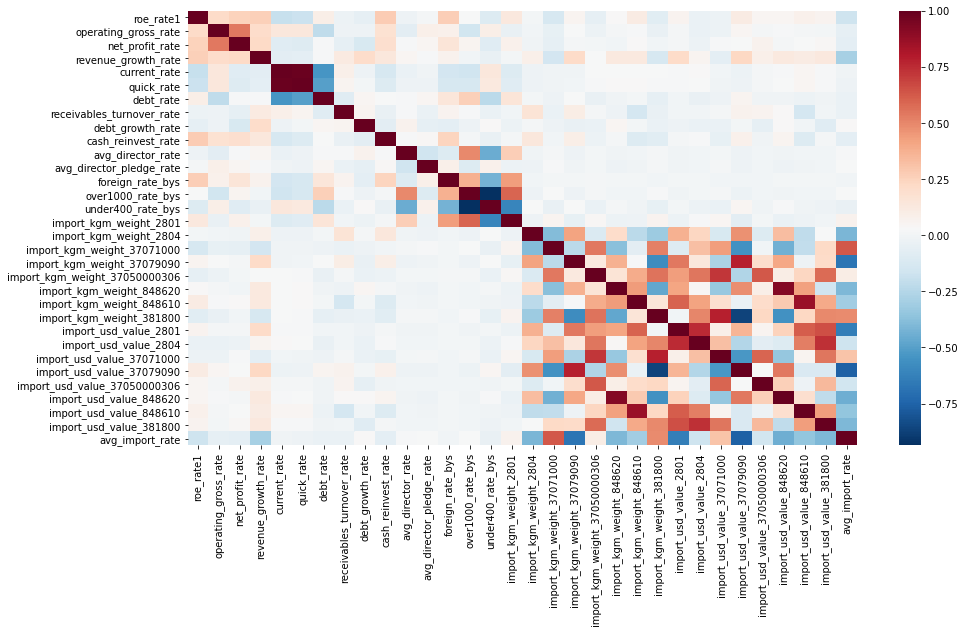

In [197]:
df1 = pd.merge(Roe_rul['roe_rate1'], addenv_factor,left_index=True, right_index=True)
plt.figure(figsize = (15,8))
corr1 = df1.corr()
sns.heatmap(corr1, cmap="RdBu_r")

In [243]:
df1.corr()['roe_rate1']

roe_rate1                        1.000000
operating_gross_rate             0.220831
net_profit_rate                  0.252212
revenue_growth_rate              0.262203
current_rate                    -0.190676
quick_rate                      -0.176265
debt_rate                        0.099070
receivables_turnover_rate       -0.021771
debt_growth_rate                -0.052062
cash_reinvest_rate               0.277222
avg_director_rate               -0.020064
avg_director_pledge_rate         0.010512
foreign_rate_bys                 0.268198
over1000_rate_bys                0.030884
under400_rate_bys               -0.103462
import_kgm_weight_2801           0.134695
import_kgm_weight_2804           0.006785
import_kgm_weight_37071000      -0.131796
import_kgm_weight_37079090       0.056794
import_kgm_weight_37050000306   -0.053030
import_kgm_weight_848620         0.037508
import_kgm_weight_848610         0.109526
import_kgm_weight_381800        -0.080505
import_usd_value_2801            0

In [244]:
high_corr1 = df1.columns[df1.corr()['roe_rate1'].abs()> 0.1]
high_corr1 = high_corr1.drop('roe_rate1')
high_corr1

Index(['operating_gross_rate', 'net_profit_rate', 'revenue_growth_rate',
       'current_rate', 'quick_rate', 'cash_reinvest_rate', 'foreign_rate_bys',
       'under400_rate_bys', 'import_kgm_weight_2801',
       'import_kgm_weight_37071000', 'import_kgm_weight_848610',
       'import_usd_value_37079090', 'avg_import_rate'],
      dtype='object')

In [245]:
X1 = addenv_factor[high_corr1]
y1 = Roe_rul['roe_rate1']
print("X1.shape: " ,X1.shape)
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())

X1.shape:  (1639, 13)
y1.shape:  (1639,)
y1.sum(): 884


In [246]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [247]:
X1_scaled = pd.DataFrame()
a, b = X1.shape

for i in range(b):
    x1_new = mean_norm(X1[X1.columns[i]])
    X1_scaled.insert(i,X1.columns[i],x1_new)
    
X1_scaled

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,cash_reinvest_rate,foreign_rate_bys,under400_rate_bys,import_kgm_weight_2801,import_kgm_weight_37071000,import_kgm_weight_848610,import_usd_value_37079090,avg_import_rate
0,0.310530,0.214147,0.195944,-0.553189,-0.513366,-0.205327,-0.641917,-0.635222,-0.310411,0.838809,0.661580,-1.496335,0.561617
1,0.420361,0.060193,-0.294623,-0.520781,-0.494960,-0.239816,-0.641917,-0.630684,-0.301024,1.698021,-1.267097,-0.823357,0.761148
2,0.272657,-0.095466,-0.436961,-0.507650,-0.496387,-0.225158,-0.643402,-0.650854,-0.298135,-0.555521,-0.006677,-1.500584,0.738125
3,0.085944,0.155633,-0.335329,-0.500379,-0.482945,-0.168251,-0.646868,-0.659426,-0.290191,0.912174,0.427587,-1.020856,1.074696
4,-0.039793,0.004708,-0.442476,-0.512620,-0.477102,0.017126,-0.646868,-0.662956,-0.282970,0.469143,-0.673308,-0.224911,1.141572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.022697,0.240658,0.719600,-0.102197,-0.251399,-0.357940,1.941256,-0.432514,-0.213645,-0.082614,1.081587,0.332627,-0.047939
1635,-0.192042,0.167942,0.016839,-0.174049,-0.299321,0.204228,1.671897,-0.092144,-0.398512,0.277597,-1.157454,0.987518,-0.291323
1636,-0.273468,0.253157,-0.368156,-0.005312,-0.137752,0.097313,1.394616,0.256798,-0.465671,-2.130997,-0.523853,0.840153,-0.775898
1637,-0.256804,0.519405,-0.336905,-0.127359,-0.166362,0.617232,1.470868,0.224021,-0.449784,-1.124863,-0.768555,1.239036,-1.560866


In [248]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.2,random_state=1)
N, D = X1_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 13


<h2> 2-1 以 DNN 實作預測 ROE 加入美元匯率 avg_import_rate

In [249]:
# 建立TF模型 for 淨利
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model2.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [250]:
model2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 256)               3584      
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_39 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 7,713
Trainable params: 7,713
Non-trainable params: 0
_________________________________________________________________


In [251]:
# 訓練模型
r2 = model2.fit(X1_train, y1_train, validation_data=(X1_test, y1_test), epochs=100)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model2.evaluate(X1_train, y1_train))
print("Test score:", model2.evaluate(X1_test, y1_test))

Epoch 1/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5622 - val_loss: 0.6332 - val_accuracy: 0.6707
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6313 - accuracy: 0.6560 - val_loss: 0.5990 - val_accuracy: 0.6982
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5960 - accuracy: 0.6880 - val_loss: 0.5768 - val_accuracy: 0.7043
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5774 - accuracy: 0.7170 - val_loss: 0.5598 - val_accuracy: 0.7134
Epoch 5/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.7071 - val_loss: 0.5464 - val_accuracy: 0.7195
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5478 - accuracy: 0.7208 - val_loss: 0.5351 - val_accuracy: 0.7287
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5385 - accuracy: 0.7376 - val_loss: 0.5248 - val_accuracy: 0.7439
Epoch 8/100
4

Epoch 59/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4423 - accuracy: 0.8040 - val_loss: 0.4782 - val_accuracy: 0.7805
Epoch 60/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.8063 - val_loss: 0.4788 - val_accuracy: 0.7774
Epoch 61/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4499 - accuracy: 0.8146 - val_loss: 0.4792 - val_accuracy: 0.7835
Epoch 62/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.8055 - val_loss: 0.4821 - val_accuracy: 0.7744
Epoch 63/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4414 - accuracy: 0.8055 - val_loss: 0.4814 - val_accuracy: 0.7835
Epoch 64/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.8009 - val_loss: 0.4807 - val_accuracy: 0.7835
Epoch 65/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.8124 - val_loss: 0.4815 - val_accuracy: 0.7835
Epoch 

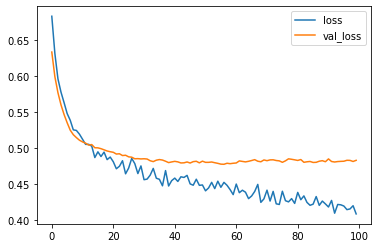

In [252]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r2.history['loss'], label='loss')
plt.plot(r2.history['val_loss'], label='val_loss')
plt.legend()

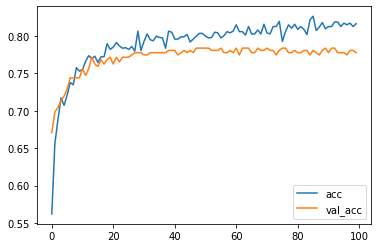

In [253]:
# 劃出準確性 accuracy 
plt.plot(r2.history['accuracy'], label='acc')
plt.plot(r2.history['val_accuracy'], label='val_acc')
plt.legend()

In [254]:
pred_test = model2.predict(X1_test)
pred_test = np.round(pred_test).flatten()
cm2 = confusion_matrix(y1_test, pred_test)
cm2

array([[109,  39],
       [ 34, 146]], dtype=int64)

In [255]:
# model3.save('./ROE_model.h5')

<H1>3. 加入全部環境因素 特徵篩選

In [26]:
#取得需要的特徵
addenv_factor2 = get_data("""SELECT *
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

addenv_factor2 = addenv_factor2.drop(['stock_code','stock_report_date'],axis=1)
addenv_factor2

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,roe_rate,roa_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,1.07,0.91,...,433,15698,18323,61504,3021,107270,0.00,0.00,0.00,0.00
1,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,0.42,0.37,...,395,17864,27973,93168,2669,112119,0.00,0.00,0.00,0.00
2,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,-0.20,-0.14,...,309,16779,17192,72410,4024,96978,0.00,0.00,0.00,0.00
3,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,0.85,0.74,...,326,19927,19788,77517,3432,98799,0.00,0.00,0.00,0.00
4,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,0.17,0.17,...,339,20499,19911,118643,3547,90681,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-0.03,6.29,4.71,...,378,22722,18682,71220,2776,95038,1818.75,5251.16,6.72,0.00
1635,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,4.01,2.97,...,474,20831,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00
1636,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,6.07,4.61,...,362,21623,21166,88039,509,96949,50018.10,27565.47,4.07,0.00
1637,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,11.76,8.79,...,338,22734,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29


<AxesSubplot:>

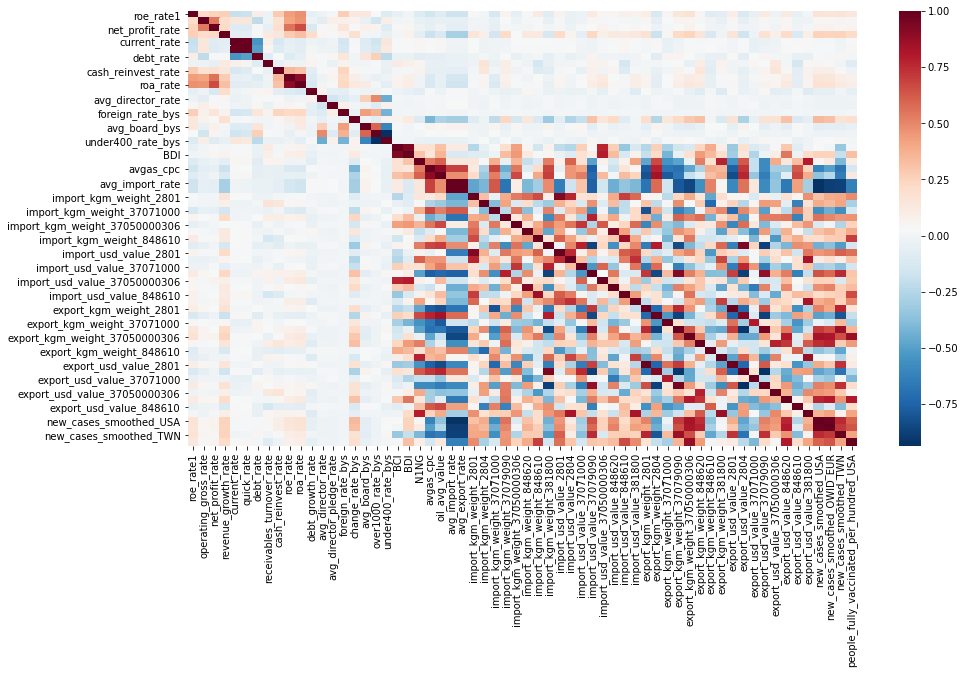

In [27]:
df2 = pd.merge(Roe_rul['roe_rate1'], addenv_factor2,left_index=True, right_index=True)
plt.figure(figsize = (15,8))
corr2 = df2.corr()
sns.heatmap(corr2, cmap="RdBu_r")

In [45]:
df2.corr()['roe_rate1'].head(20)

roe_rate1                    1.000000
operating_gross_rate         0.220831
net_profit_rate              0.252212
revenue_growth_rate          0.262203
current_rate                -0.190676
quick_rate                  -0.176265
debt_rate                    0.099070
receivables_turnover_rate   -0.021771
cash_reinvest_rate           0.277222
roe_rate                     0.433484
roa_rate                     0.474984
debt_growth_rate            -0.052062
avg_director_rate           -0.020064
avg_director_pledge_rate     0.010512
foreign_rate_bys             0.268198
change_rate_bys              0.131795
avg_board_bys                0.134695
over1000_rate_bys            0.030884
under400_rate_bys           -0.103462
BCI                         -0.044708
Name: roe_rate1, dtype: float64

In [78]:
high_corr2 = df2.columns[df2.corr()['roe_rate1'].abs() > 0.16]
high_corr2 = high_corr2.drop('roe_rate1')
print(high_corr2)

Index(['operating_gross_rate', 'net_profit_rate', 'revenue_growth_rate',
       'current_rate', 'quick_rate', 'cash_reinvest_rate', 'roe_rate',
       'roa_rate', 'foreign_rate_bys', 'avg_import_rate', 'avg_export_rate',
       'export_kgm_weight_37050000306', 'new_cases_smoothed_USA',
       'new_cases_smoothed_TWN'],
      dtype='object')


In [79]:
X2 = addenv_factor2[high_corr2]

y1 = Roe_rul['roe_rate1']
print("X2.shape: " ,X2.shape)
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())

X2.shape:  (1639, 14)
y1.shape:  (1639,)
y1.sum(): 884


In [80]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [81]:
X2_scaled = pd.DataFrame()
a, b = X2.shape

for i in range(b):
    x2_new = mean_norm(X2[X2.columns[i]])
    X2_scaled.insert(i,X2.columns[i],x2_new)
X2_scaled

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,cash_reinvest_rate,roe_rate,roa_rate,foreign_rate_bys,avg_import_rate,avg_export_rate,export_kgm_weight_37050000306,new_cases_smoothed_USA,new_cases_smoothed_TWN
0,0.310530,0.214147,0.195944,-0.553189,-0.513366,-0.205327,-0.182515,-0.220846,-0.641917,0.561617,0.561617,-0.899728,-0.625915,-0.874567
1,0.420361,0.060193,-0.294623,-0.520781,-0.494960,-0.239816,-0.290044,-0.381183,-0.641917,0.761148,0.761148,-0.798707,-0.625915,-0.874567
2,0.272657,-0.095466,-0.436961,-0.507650,-0.496387,-0.225158,-0.392611,-0.532612,-0.643402,0.738125,0.738125,-0.160078,-0.625915,-0.874567
3,0.085944,0.155633,-0.335329,-0.500379,-0.482945,-0.168251,-0.218909,-0.271322,-0.646868,1.074696,1.074696,-0.185083,-0.625915,-0.874567
4,-0.039793,0.004708,-0.442476,-0.512620,-0.477102,0.017126,-0.331402,-0.440567,-0.646868,1.141572,1.141572,-0.805709,-0.625915,-0.874567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.022697,0.240658,0.719600,-0.102197,-0.251399,-0.357940,0.681029,0.907451,1.941256,-0.047939,-0.047939,-0.401627,-0.588310,1.381120
1635,-0.192042,0.167942,0.016839,-0.174049,-0.299321,0.204228,0.303849,0.390810,1.671897,-0.291323,-0.291323,-0.176081,-0.083800,0.582231
1636,-0.273468,0.253157,-0.368156,-0.005312,-0.137752,0.097313,0.644634,0.877759,1.394616,-0.775898,-0.775898,0.489554,0.408293,0.491601
1637,-0.256804,0.519405,-0.336905,-0.127359,-0.166362,0.617232,1.585929,2.118886,1.470868,-1.560866,-1.560866,0.711099,2.160336,1.488534


In [82]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X2_train, X2_test, y1_train, y1_test = train_test_split(X2_scaled, y1, test_size=0.2,random_state=1)
N, D = X2_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 14


In [83]:
# 建立TF模型 for 淨利
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.8),
#   tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model3.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [84]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               3840      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 8,033
Trainable params: 8,001
Non-trainable params: 32
___________________________________________________

In [85]:
# 訓練模型
r3 = model3.fit(X2_train, y1_train, validation_data=(X2_test, y1_test), epochs=100)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model3.evaluate(X2_train, y1_train))
print("Test score:", model3.evaluate(X2_test, y1_test))

Epoch 1/100
41/41 [==============================] - 1s 4ms/step - loss: 0.9092 - accuracy: 0.5019 - val_loss: 0.6128 - val_accuracy: 0.7287
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.7724 - accuracy: 0.5866 - val_loss: 0.5662 - val_accuracy: 0.7256
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.6217 - val_loss: 0.5392 - val_accuracy: 0.7530
Epoch 4/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.6484 - val_loss: 0.5219 - val_accuracy: 0.7652
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6449 - accuracy: 0.6697 - val_loss: 0.5132 - val_accuracy: 0.7622
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5893 - accuracy: 0.7071 - val_loss: 0.5071 - val_accuracy: 0.7591
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6008 - accuracy: 0.7025 - val_loss: 0.5058 - val_accuracy: 0.7561
Epoch 8/100
4

Epoch 59/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4850 - accuracy: 0.7994 - val_loss: 0.4726 - val_accuracy: 0.8110
Epoch 60/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4782 - accuracy: 0.8009 - val_loss: 0.4726 - val_accuracy: 0.8110
Epoch 61/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4747 - accuracy: 0.7994 - val_loss: 0.4729 - val_accuracy: 0.8140
Epoch 62/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4845 - accuracy: 0.7841 - val_loss: 0.4730 - val_accuracy: 0.8140
Epoch 63/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.8055 - val_loss: 0.4723 - val_accuracy: 0.8110
Epoch 64/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4765 - accuracy: 0.7849 - val_loss: 0.4710 - val_accuracy: 0.8140
Epoch 65/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.7918 - val_loss: 0.4719 - val_accuracy: 0.8110
Epoch 

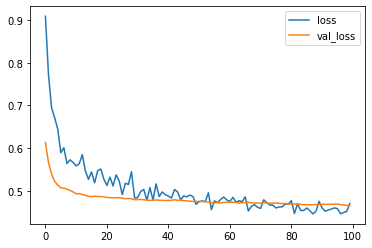

In [86]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r3.history['loss'], label='loss')
plt.plot(r3.history['val_loss'], label='val_loss')
plt.legend()

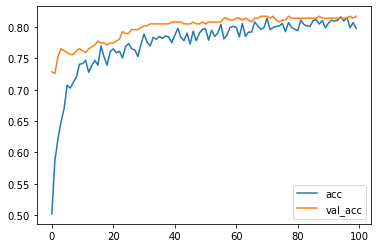

In [87]:
# 劃出準確性 accuracy 
plt.plot(r3.history['accuracy'], label='acc')
plt.plot(r3.history['val_accuracy'], label='val_acc')
plt.legend()

In [88]:
pred_test = model3.predict(X2_test)
pred_test = np.round(pred_test).flatten()
cm3 = confusion_matrix(y1_test, pred_test)
cm3

array([[110,  38],
       [ 22, 158]], dtype=int64)